In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams

/home/hieuiph/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [4]:
rcParams['figure.figsize'] = 12, 4

In [5]:
train = pd.read_csv('ech_apprentissage.csv', delimiter=';')
target = 'prime_tot_ttc'
train.head()

/home/hieuiph/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,...,var14,var15,var16,var17,var18,var19,var20,var21,var22,prime_tot_ttc
0,1,1986.0,2006.0,RENAULT,4,1,1034,gpl,2924,68,...,N,1,1,1,27,0,0,0,1,254.75
1,2,1986.0,2006.0,RENAULT,8,2,1034,gpl,11580,50,...,N,2,1,1,28,0,0,0,1,259.89
2,3,1982.0,2001.0,RENAULT,7,2,1034,gpl,7149,95,...,N,3,1,1,29,0,0,0,1,431.65
3,4,1987.0,2006.0,DACIA,5,2,1034,gpl,6526,100,...,N,3,1,1,29,0,0,0,1,577.99
4,5,1994.0,2013.0,CITROEN,4,2,1034,gpl,2872,50,...,N,2,1,4,26,0,1,1,4,222.67


In [6]:
predictors = [x for x in train.columns if x not in [target,'id']]
print predictors

['annee_naissance', 'annee_permis', 'marque', 'puis_fiscale', 'anc_veh', 'codepostal', 'energie_veh', 'kmage_annuel', 'crm', 'profession', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21', 'var22']


In [7]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          metrics='auc',early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        
        alg.fit(dtrain[predictors], dtrain['prime_tot_ttc'],eval_metric='auc')
        
        dtrain_predictors = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        print "\nModel Report"
        print "Accuracy: %.4g" % metrics.accuracy_score(dtrain['prime_tot_ttc'].values, dtrain_predictions)
        
        feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importance')
        ply.ylabel('Feature Importance Score')

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder()
train_y = train['prime_tot_ttc']
train_X = train[predictors]

In [10]:
train.dtypes
categoricals = ['marque','codepostal','energie_veh','profession','var6','var7','var8','var14','var16']

In [11]:
test = pd.read_csv('ech_test.csv',delimiter=';')
test.head()

,id,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,...,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22
0,300001,1992.0,2011.0,RENAULT,4,2,97109,essence,2983,88,...,3,N,0,1,0,20,2,0,1,0
1,300002,1991.0,2010.0,RENAULT,6,36,97109,essence,6496,50,...,5,N,0,4,1,20,1,0,1,0
2,300003,1976.0,1995.0,RENAULT,10,3,97109,essence,6971,50,...,5,N,7,1,1,21,1,0,1,0
3,300004,1976.0,1995.0,BMW,13,1,97109,essence,7293,68,...,4,N,0,1,1,22,1,0,1,0
4,300005,1984.0,2004.0,PEUGEOT,9,0,97109,essence,6982,50,...,5,N,2,4,1,16,0,0,1,1


In [12]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
                              if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                              index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [13]:
big_X = train[predictors].append(test[predictors])
bigX_imputed = DataFrameImputer().fit_transform(big_X)

In [14]:
bigX_imputed.head()

,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,profession,...,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22
0,1986.0,2006.0,RENAULT,4,1,1034,gpl,2924,68,"enseignant, formateur, chercheur",...,3,N,1,1,1,27,0,0,0,1
1,1986.0,2006.0,RENAULT,8,2,1034,gpl,11580,50,"enseignant, formateur, chercheur",...,5,N,2,1,1,28,0,0,0,1
2,1982.0,2001.0,RENAULT,7,2,1034,gpl,7149,95,"enseignant, formateur, chercheur",...,5,N,3,1,1,29,0,0,0,1
3,1987.0,2006.0,DACIA,5,2,1034,gpl,6526,100,"enseignant, formateur, chercheur",...,5,N,3,1,1,29,0,0,0,1
4,1994.0,2013.0,CITROEN,4,2,1034,gpl,2872,50,"cadre, ingenieur",...,5,N,2,1,4,26,0,1,1,4


In [15]:
le = LabelEncoder()
for feature in categoricals:
    bigX_imputed[feature] = le.fit_transform(bigX_imputed[feature])

In [16]:
bigX_imputed.head()

,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,profession,...,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22
0,1986.0,2006.0,118,4,1,21,4,2924,68,9,...,3,7,1,1,1,27,0,0,0,1
1,1986.0,2006.0,118,8,2,21,4,11580,50,9,...,5,7,2,1,1,28,0,0,0,1
2,1982.0,2001.0,118,7,2,21,4,7149,95,9,...,5,7,3,1,1,29,0,0,0,1
3,1987.0,2006.0,31,5,2,21,4,6526,100,9,...,5,7,3,1,1,29,0,0,0,1
4,1994.0,2013.0,29,4,2,21,4,2872,50,3,...,5,7,2,1,4,26,0,1,1,4


In [17]:
train_X = bigX_imputed[0:train.shape[0]].as_matrix()
test_X = bigX_imputed[train.shape[0]::].as_matrix()
train_y = train['prime_tot_ttc']

In [18]:
from sklearn.grid_search import GridSearchCV

In [17]:
xgb_model = xgb.XGBRegressor()

In [18]:
clf = GridSearchCV(xgb_model, {'max_depth': [2,4,6],'n_estimators':[50,100,200]},verbose=1)

In [19]:
clf.fit(train_X,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 25.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [20]:
print (clf.best_score_)
print (clf.best_params_)

0.883246678996
{'n_estimators': 200, 'max_depth': 6}


In [21]:
gbm = xgb.XGBRegressor(max_depth=6, n_estimators=200).fit(train_X,train_y)

In [22]:
predictions = gbm.predict(test_X)

In [23]:
predictions

array([ 321.759552  ,  214.60842896,  268.43692017, ...,  401.19396973,
        372.39825439,  332.95550537], dtype=float32)

In [24]:
len(predictions)

30000

In [31]:
submission = pd.DataFrame({'ID;': test['id'],'COTIS': predictions})

In [32]:
submission.head()

,COTIS,ID;
0,321.759552,300001
1,214.608429,300002
2,268.436920,300003
3,351.821625,300004
4,317.463013,300005


In [33]:
cols = submission.columns.tolist()
cols

['COTIS', 'ID;']

In [35]:
cols = cols[-1:] + cols[:-1]
cols

['ID;', 'COTIS']

In [36]:
submission = submission[cols]

In [37]:
submission.head()

,ID;,COTIS
0,300001,321.759552
1,300002,214.608429
2,300003,268.436920
3,300004,351.821625
4,300005,317.463013


In [38]:
submission['ID;'] = map(lambda x: str(x) + ';', submission['ID;'] )

In [40]:
submission.head()

,ID;,COTIS
0,300001;,321.759552
1,300002;,214.608429
2,300003;,268.436920
3,300004;,351.821625
4,300005;,317.463013


In [42]:
submission.to_csv("submission.csv",sep=' ',index=False)

# cherche des parametres optimisant la performance

In [45]:
xgb_params = {"objective":"reg:linear","eta":0.01,"max_depth":8,"seed":42,"silent":1}
num_rounds = 1000

In [19]:
dtrain = xgb.DMatrix(train_X,label=train_y)

In [47]:
dtrain

In [48]:
gbdt = xgb.train(xgb_params,dtrain,num_rounds)

In [51]:
def create_feature_map(features):
    outfile = open('xgb.fmap','w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
        i = i+1
    outfile.close()
create_feature_map(predictors)    
import operator
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(),key=operator.itemgetter(1))

In [52]:
df = pd.DataFrame(importance, columns=['feature','fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

In [53]:
df.head()

,feature,fscore
0,var3,0.001501
1,var21,0.001858
2,var20,0.002236
3,var16,0.002724
4,var17,0.004809


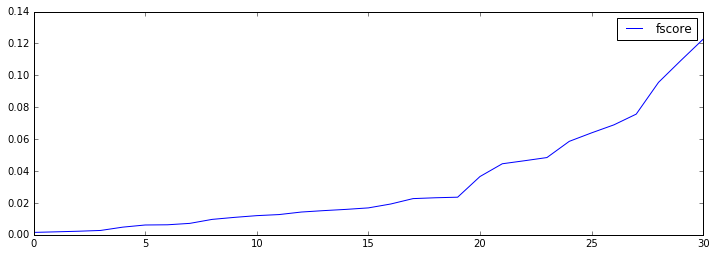

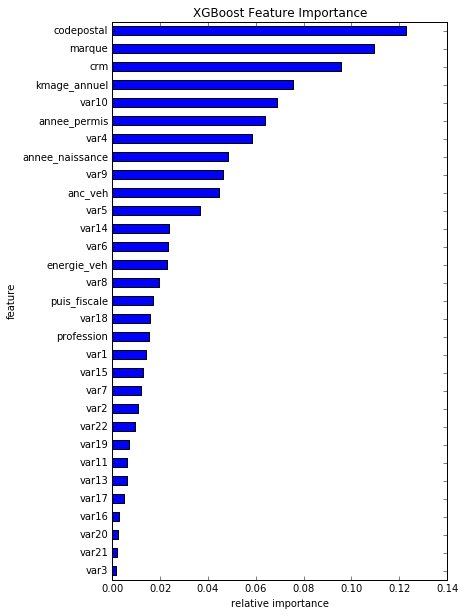

In [56]:
plt.figure()
df.plot()
df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

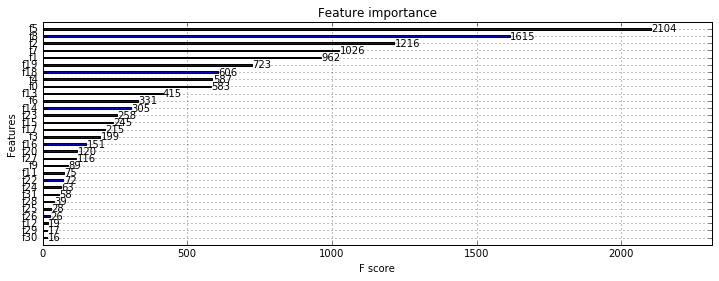

In [57]:
xgb.plot_importance(gbm)

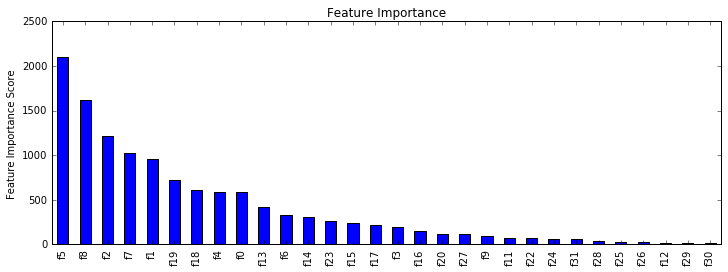

In [59]:
feat_imp = pd.Series(gbm.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar',title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [62]:
gbdt.dump_model('dump.raw.txt')

In [63]:
pred_train = gbdt.predict(dtrain)
print('best ite:', gbdt.best_iteration)

('best ite:', 999)


# Tune max_depth and min_child_weight

In [64]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight':range(1,6,2)
}

In [65]:
gsearch1 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,n_estimators=140,max_depth=5,min_child_weight=1,
                                                  gamma=0,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,
                                                  seed=27),param_grid=param_test1,n_jobs=4,iid=False,cv=5)

In [66]:
gsearch1.fit(train_X,train_y)

/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_vi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
gsearch1.grid_scores_, gsearch1.best_params_,gsearch1.best_score_

([mean: 0.85407, std: 0.00253, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.85446, std: 0.00265, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.85470, std: 0.00141, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87918, std: 0.00447, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87866, std: 0.00482, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.87927, std: 0.00393, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.88650, std: 0.00634, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.88689, std: 0.00612, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.88734, std: 0.00504, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.88792, std: 0.00659, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.88680, std: 0.00605, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.88774, std: 0.00798, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 1

# Deeper and look for optimum values

In [20]:
from sklearn.grid_search import GridSearchCV

param_test3 = {
    'gamma': [i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,n_estimators=140,max_depth=9,min_child_weight=1,
                                                  gamma=0,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,
                                                  seed=27),param_grid=param_test3,n_jobs=4,iid=False,cv=5)

In [21]:
gsearch3.fit(train_X,train_y)

/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/hieuiph/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_vi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
gsearch3.grid_scores_,gsearch3.best_params_,gsearch3.best_score_

([mean: 0.88792, std: 0.00659, params: {'gamma': 0.0},
  mean: 0.88792, std: 0.00659, params: {'gamma': 0.1},
  mean: 0.88790, std: 0.00660, params: {'gamma': 0.2},
  mean: 0.88790, std: 0.00660, params: {'gamma': 0.3},
  mean: 0.88790, std: 0.00660, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.88791738040879087)

In [24]:
xgbmodel2 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                                                  gamma=0,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,
                                                  seed=27).fit(train_X,train_y)

In [25]:
predictions2 = xgbmodel2.predict(test_X)

In [26]:
predictions2

array([ 321.01367188,  225.63517761,  274.85089111, ...,  430.85952759,
        378.93988037,  341.62164307], dtype=float32)

In [29]:
def summision(prediction,test):
    
    submission2 = pd.DataFrame({'ID;': test['id'],'COTIS': prediction})
    submission2['ID;'] = map(lambda x: str(x) + ';', submission2['ID;'] )
    cols = submission2.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    submission2 = submission2[cols]
    submission2.to_csv("submission3.csv",sep=' ',index=False)

In [30]:
summision(predictions2,test)